<a href="https://colab.research.google.com/github/jmcaussade/analitica-textual-con-machine-learning-tarea4/blob/main/Oficial_Lab_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#Laboratorio 4 - Comparación de Modelos Preentrenados y Cuantización con BitsandBytes
#Curso Analítica Textual con Machine Learning

Profesora: Carla Vairetti



En este laboratorio, nos enfocaremos en entrenar y comparar distintos modelos preentrenados disponibles en la biblioteca Hugging Face. Evaluaremos su rendimiento en una tarea de clasificación binaria, observando cómo las diferentes arquitecturas y tamaños de modelos afectan el desempeño en términos de precisión y eficiencia.

## Comparación de Modelos Preentrenados
Hugging Face ofrece una amplia gama de modelos preentrenados, que se adaptan a diferentes tipos de tareas. En este laboratorio, seleccionaremos varios de estos modelos y los entrenaremos bajo las mismas condiciones para realizar una comparación exhaustiva de sus rendimientos. Consideraremos métricas como accuracy, F1 score y tiempo de entrenamiento para tener una visión clara de las fortalezas y debilidades de cada modelo en la tarea de clasificación binaria.

## Introducción a BitsandBytes para Cuantización

La cuantización con BitsandBytes es una técnica utilizada para reducir el tamaño y mejorar la eficiencia computacional de los modelos de aprendizaje automático, particularmente los modelos de lenguaje grandes (LLMs). Esta técnica permite que los modelos se ejecuten de manera más eficiente en hardware con menos capacidad (como GPUs con menos memoria) al reducir la precisión numérica de los cálculos que realizan, sin sacrificar demasiado su rendimiento o precisión.

Para este fin, introduciremos la librería `bitsandbytes`, que proporciona métodos eficientes para cuantizar modelos entrenados.

### ¿Cómo funciona?
BitsandBytes es una biblioteca que soporta diferentes tipos de cuantización para modelos de lenguaje. La cuantización consiste en reducir el número de bits utilizados para representar los pesos y activaciones de un modelo. En lugar de utilizar números de 32 bits (precisión estándar en muchas operaciones de deep learning), la cuantización puede reducir esos números a representaciones de 16, 8 o incluso menos bits.

### Tipos de cuantización que soporta BitsandBytes:

1. **Cuantización de 8 bits (int8):** Convierte los pesos de 32 bits flotantes (fp32) a 8 bits enteros (int8), lo que reduce significativamente el uso de memoria. Esto es útil para desplegar modelos en hardware más limitado, permitiendo realizar inferencias más rápidas y usando menos memoria.

2. **Cuantización de 4 bits (int4):** Similar a int8, pero aún más eficiente en términos de memoria, al reducir la representación de los pesos a solo 4 bits.

3. **Cuantización mixta:** BitsandBytes también soporta enfoques de precisión mixta, donde solo algunas partes del modelo son cuantizadas para mantener un balance entre eficiencia y rendimiento.

Esto se puede lograr utilizando el parámetro `load_in_4bit=True` o `load_in_8bit=True` al cargar un modelo con la librería `transformers`. Esta funcionalidad permite que los modelos ocupen menos espacio y aceleren la inferencia sin perder un rendimiento significativo.

### Ventajas:

- **Reducción de memoria:** La cuantización con BitsandBytes permite que modelos muy grandes puedan ejecutarse en hardware más accesible al reducir su tamaño en memoria.

- **Mejora en la velocidad:** Al disminuir la precisión de los cálculos, las operaciones se vuelven más rápidas, lo que acelera las inferencias.

- **Ahorro de costos:** Menos memoria y menos uso computacional se traducen en menores costos en infraestructura de hardware.

### Desventajas:

- **Pérdida de precisión:** Aunque la reducción de bits mejora la eficiencia, puede haber una leve degradación en el rendimiento del modelo debido a la menor precisión en los cálculos.

BitsandBytes es particularmente útil cuando se trabaja con modelos grandes como GPT, BERT o cualquier otro que pueda requerir una gran cantidad de recursos computacionales, y es muy popular en la comunidad de machine learning por su capacidad de cuantizar modelos sin pérdida significativa en su rendimiento.


### Modelos Simples y Cuantización
En este laboratorio, estamos utilizando modelos más simples que no requieren el uso obligatorio de cuantización en 4 o 8 bits, ya que no son tan pesados como los modelos de generación de lenguaje como Llama 3.1 o Mixtral, que son comúnmente usados en tareas generativas. Aunque es posible aplicar la cuantización en estos modelos simples, no es estrictamente necesario debido a su menor tamaño y requisitos computacionales más bajos. Esto nos permite evaluar la eficiencia de estos modelos sin necesidad de recursos tan intensivos como los utilizados para modelos de generación de texto a gran escala.


In [1]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 6.7 MB/s eta 0:00:00



## Paso 1: Montar Google Drive
Comenzamos montando Google Drive para acceder al conjunto de datos y guardar cualquier salida.


In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive



## Paso 2: Importar las Bibliotecas Necesarias
A continuación, importamos las bibliotecas necesarias. Estas incluyen:
- `transformers` para cargar y trabajar con modelos transformadores,
- `pandas` y `numpy` para el manejo de datos,
- `torch` para trabajar con PyTorch (la base de nuestros modelos),
- `sklearn` para evaluar el modelo,
- `matplotlib` y `seaborn` para realizar gráficos.


In [3]:
import io
import os
import copy
import torch
import json
import torch
import os
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import bitsandbytes as bnb
import torch.nn.functional as F
from transformers import (AutoConfig,
                          AutoModelForSequenceClassification,
                          AutoTokenizer, AdamW,
                          get_linear_schedule_with_warmup,
                          set_seed,
                          )
from sklearn.utils.class_weight import compute_class_weight
import warnings

tqdm.pandas()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

warnings.filterwarnings("ignore", category=UserWarning)




## Paso 3: Definir Hiperparámetros
Definimos algunos hiperparámetros esenciales:
- `max_length`: La longitud máxima de la entrada tokenizada.
- `epochs`: Número de épocas de entrenamiento.
- `batch_size`: El tamaño del lote para el entrenamiento.
- `n_labels`: Número de etiquetas en la tarea de clasificación.
- `learning_rate`: La tasa de aprendizaje para el optimizador.


In [4]:
max_length = 512
epochs = 5
batch_size = 4
n_labels = 3
warmup_epochs = 0.2 * epochs
learning_rate = 1e-5

## Paso 4: Configuración HuggingFace

Para ciertos modelos es necesario pedir acceso a los autores utilizando la plataforma de HuggingFace, para esto es necesario tener una cuenta (pueden ingresar utilizando su cuenta Google) https://huggingface.co/



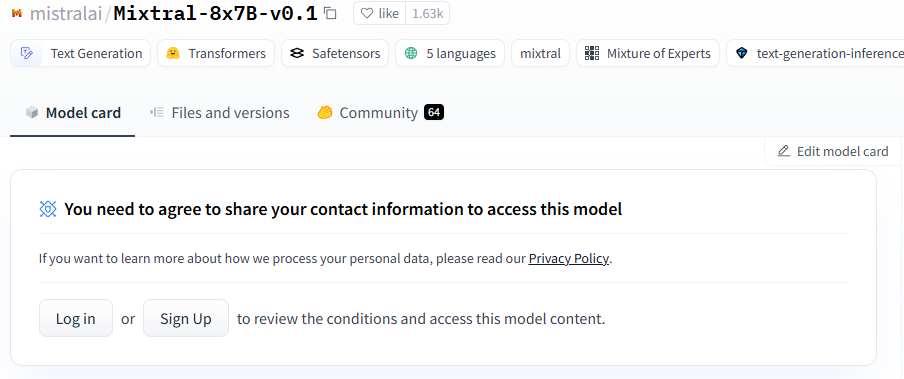

Una vez que ingresen a su cuenta de Hugging Face y obtengan acceso al modelo, diríjanse a la sección de configuración de su perfil. Allí encontrarán la opción para crear su Access Token. **Recuerden que este token es privado y personal, por lo que es fundamental mantenerlo seguro y no compartirlo con nadie.**

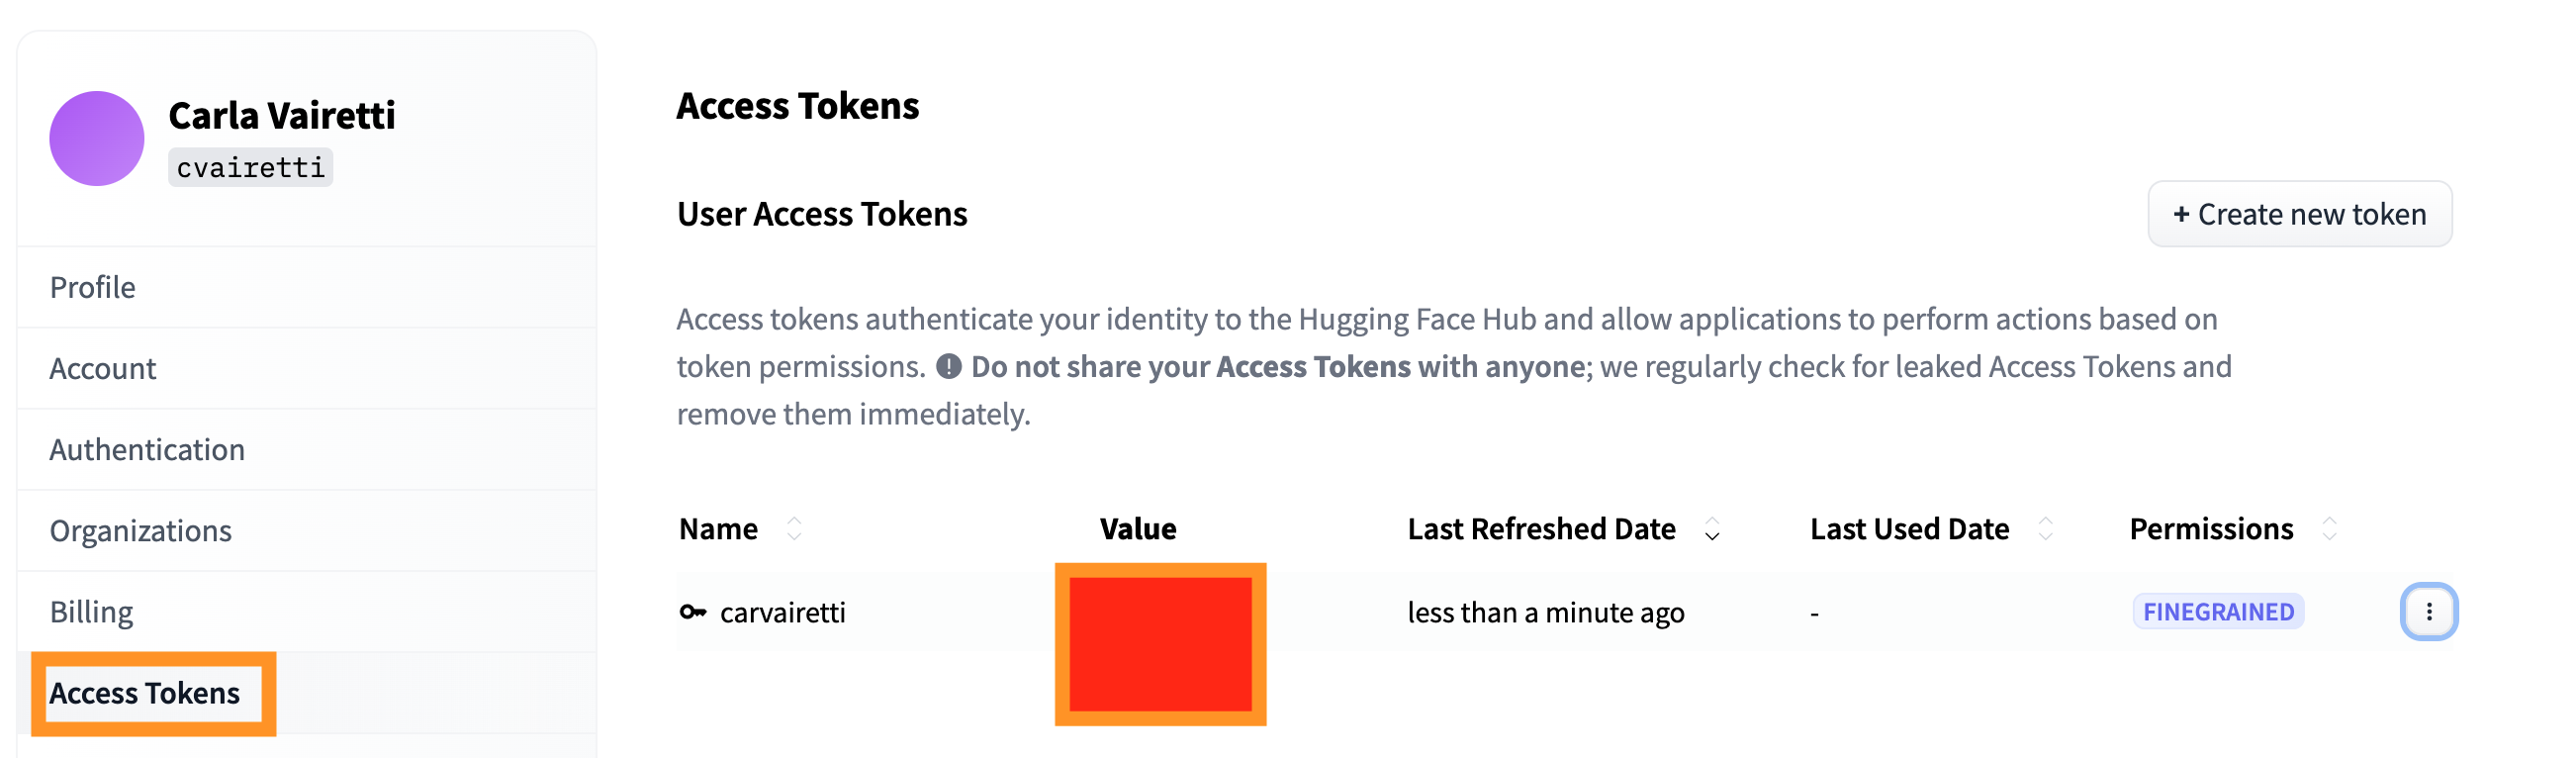

Por ultimo podemos utilizar la funcionalidad de "Secrets" / "secretos" de Google Colab que se encuentra en la mano izquierda del Notebook (Icono de llave), ahi se puede crear un nuevo secreto con el valor de su access token de HuggingFace utilizando el nombre 'huggingface'

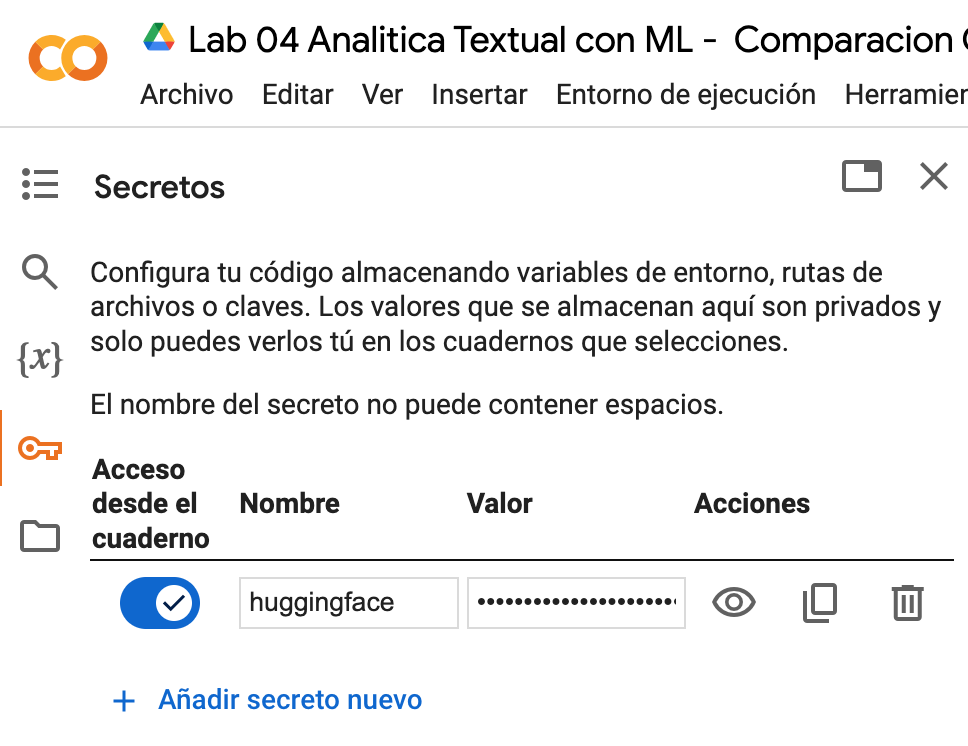

In [5]:
from google.colab import userdata
access_token = userdata.get('HuggingFace')


## Paso 5: Selección de Modelos



En el siguiente fragmento de código, se define un diccionario llamado models, el cual asocia nombres de diferentes modelos de lenguaje preentrenados con sus respectivas rutas en Hugging Face. Estos modelos han sido optimizados para tareas de procesamiento del lenguaje natural (PLN) en español, abarcando tanto variantes generales del idioma como adaptaciones específicas a contextos locales, como el español chileno. Entre los modelos incluidos se encuentran versiones de BERT, Patana y Tulio, así como arquitecturas especializadas como RoBERTa, ALBERT y Longformer, cada una seleccionada por sus características particulares para distintas tareas de PLN.

In [6]:
models = {
    'BERT': 'dccuchile/bert-base-spanish-wwm-cased',
    'PATANA': 'dccuchile/patana-chilean-spanish-bert',
    'TULIO': 'dccuchile/tulio-chilean-spanish-bert',
    'ROBERTA': 'bertin-project/bertin-roberta-base-spanish',
    'ALBERT': 'dccuchile/albert-xlarge-spanish',
    'LONGFORMER': 'PlanTL-GOB-ES/longformer-base-4096-bne-es'
}

### Analisis Comparativo Entre Modelos

1. ***BERT*** (dccuchile/bert-base-spanish-wwm-cased)

    **Descripción técnica:** BERT es un modelo basado en transformers que aplica un enfoque bidireccional, permitiendo que la representación de las palabras esté influenciada por el contexto tanto a la izquierda como a la derecha. El modelo BERT entrenado en español usa Whole Word Masking, lo que significa que se enmascaran palabras completas en lugar de sub-palabras, mejorando el entrenamiento en palabras compuestas.

    **Ventajas:** Excelente en generalizar en problemas de NLP con múltiples clases.

    **Desventajas:** Modelo pesado en términos de memoria y cómputo, lo que requiere mayor tiempo de entrenamiento.

2. ***PATANA*** (dccuchile/patana-chilean-spanish-bert)

    **Descripción técnica:** PATANA es una variante de BERT preentrenada específicamente en español chileno, lo que le permite captar modismos y particularidades del español hablado en Chile. Esto lo hace un modelo especialmente interesante para tareas que involucran textos de Chile.

    **Ventajas:** Adecuado para tareas relacionadas con el español chileno. Puede mejorar la precisión en textos especializados o contextuales a esta variante del idioma.

    **Desventajas:** No necesariamente se generaliza bien para otros dialectos del español.

3. ***TULIO*** (dccuchile/tulio-chilean-spanish-bert)

    **Descripción técnica:** Similar a PATANA, pero con un enfoque más optimizado para el español chileno y con ligeras modificaciones en el preentrenamiento. TULIO se centra en mejorar la representación lingüística en tareas que requieren comprensión profunda de estructuras gramaticales y léxicas del español en Chile.

    **Ventajas:** Un equilibrio entre especialización en español chileno y generalización para el español más amplio.

    **Desventajas:** Menor rendimiento en dialectos fuera del español chileno, aunque mejor que PATANA en términos de generalización.

4. ***ROBERTA*** (bertin-project/bertin-roberta-base-spanish)

    **Descripción técnica:** ROBERTA es una variante de BERT que optimiza ciertos aspectos como el entrenamiento dinámico de máscaras y el uso de batches más grandes. La versión "bertin-roberta-base-spanish" está entrenada en un corpus grande en español.

    **Ventajas:** Rápido y eficiente en comparación con BERT. Mejor rendimiento en tareas generales de clasificación de textos.

    **Desventajas:** Aunque es eficiente, puede no capturar matices específicos del español chileno tan bien como modelos como PATANA o TULIO.

5. ***ALBERT*** (dccuchile/albert-xlarge-spanish)

    **Descripción técnica:** ALBERT es una versión ligera y eficiente de BERT que reduce el tamaño del modelo usando técnicas como factorizar las matrices de embeddings y compartir parámetros en las capas. La versión "xlarge" ofrece mejor rendimiento con un menor costo computacional.

    **Ventajas:** Ligero, rápido y eficiente en términos de uso de memoria y entrenamiento, lo que lo hace adecuado para entornos con menos recursos computacionales.

    **Desventajas:** Aunque es más eficiente, puede sacrificar algo de capacidad para capturar dependencias complejas en comparación con BERT o ROBERTA.

6. ***LONGFORMER*** (PlanTL-GOB-ES/longformer-base-4096-bne-es)

    **Descripción técnica:** LONGFORMER es una variante que optimiza el procesamiento de secuencias largas mediante una atención local en vez de global, permitiendo llegar a un maximo de 4096 tokens. Esto lo hace ideal para textos largos donde otros modelos pueden tener problemas de truncamiento.

    **Ventajas:** Excelente para tareas con textos largos donde la comprensión del contexto a largo plazo es crucial.

    **Desventajas:** Puede ser menos eficiente en textos cortos y más costoso en términos de cómputo.


## Paso 6: Cargar los Datos
Cargamos el conjunto de datos desde el archivo Pickle creado en los laboratorios anteriores, con ratings de 1 a 3.


In [7]:
df = pd.read_pickle('/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea2ML/df_procesadoOficial.pkl')
df

,id,rank,abstract,review,processed_review,filtered_words,token_count,joined_text
0,1,2,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,"[bien, comente, propietarios, hora, abandonar,...","[hora, momento, vez, granada, situacion, centr...",76,hora momento vez granada situacion centro gran...
1,2,2,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...","[dias, familia, reservando, habitaciones, desa...","[dias, familia, incluido, incluso, parking, es...",84,dias familia incluido incluso parking estancia...
2,3,1,Decepción,Habíamos escogido este hotel por las buenas op...,"[escogido, hotel, buenas, opiniones, verdad, h...","[buenas, verdad, centro, hacia, ruido, poder, ...",53,buenas verdad centro hacia ruido poder suelo p...
3,4,2,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,"[vuelto, segunda, vez, estupendo, hotel, grana...","[vez, estupendo, granada, relacion, calidad, p...",47,vez estupendo granada relacion calidad precio ...
4,5,2,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...","[dias, granada, trabajo, autonomo, busco, ante...","[dias, granada, elegir, pues, situacion, cerca...",91,dias granada elegir pues situacion cerca grana...
...,...,...,...,...,...,...,...,...
1811,1812,2,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,"[empezado, ano, estancia, tres, noches, hotel,...","[estancia, tres, noches, lugar, tranquilo, tra...",116,estancia tres noches lugar tranquilo trato com...
1812,1813,2,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,"[atravesar, umbral, puerta, conduce, zaguan, h...","[puerta, olor, natural, patio, patio, calidad,...",242,puerta olor natural patio patio calidad vista ...
1813,1814,2,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,"[hotel, sensaciones, experiencias, positivas, ...","[ubicado, antigua, calle, ahora, junto, zona, ...",109,ubicado antigua calle ahora junto zona gran ha...
1814,1815,2,Extraordinario,Hemos pasado un par de noches en este exquisit...,"[pasado, par, noches, exquisito, hotel, regent...","[pasado, par, noches, trato, primera, planta, ...",31,pasado par noches trato primera planta cama gu...


In [8]:
df = df[['abstract', 'review', 'rank']]
df

,abstract,review,rank
0,Un hotel digno de mención!,Como bien les comenté a los propietarios a la ...,2
1,"Recomendable 100%, sin lujos pero todo perfecto.","Estuvimos dos días con mi familia, reservando ...",2
2,Decepción,Habíamos escogido este hotel por las buenas op...,1
3,"Por segunda vez, inmejorable",Hemos vuelto por segunda vez a este estupendo ...,2
4,No tan sorpresa,"He estado dos días en Granada por trabajo, soy...",2
...,...,...,...
1811,remanso de paz en el corazón de Córdoba,Hemos empezado el año con una estancia de tres...,2
1812,"Oasis de paz, tranquilidad y belleza!",Al atravesar el umbral de la puerta que conduc...,2
1813,Un lugar para recordar,En este hotel todo son sensaciones y experienc...,2
1814,Extraordinario,Hemos pasado un par de noches en este exquisit...,2


In [9]:
df.query("rank == 0").count()


,0
abstract,511
review,511
rank,511



## Paso 7: Preparar el Conjunto de Datos
Dividimos los datos en conjuntos de entrenamiento y prueba. También creamos un `Dataset` personalizado de PyTorch para manejar las entradas tokenizadas.


In [10]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=1)

La clase `DatasetFromDataFrame` es una clase personalizada que extiende la funcionalidad de `Dataset` de PyTorch para manejar datos almacenados en un DataFrame de Pandas. Esta clase facilita la preparación de datos para un modelo de aprendizaje profundo.

- **`__init__`**: Guarda el DataFrame que contiene los datos.
- **`__len__`**: Devuelve el número total de ejemplos en el dataset, es decir, el número de filas en el DataFrame.
- **`__getitem__`**: Dado un índice, recupera un ejemplo del dataset. Específicamente, devuelve la etiqueta (rating) y dos textos (el título y el comentario) correspondientes a ese índice.

In [11]:
class DatasetFromDataFrame(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        label = int(self.data.iloc[index]['rank'])
        text_1 = str(self.data.iloc[index]['abstract'])
        text_2 = str(self.data.iloc[index]['review']) ###
        return label, text_1, text_2

Ahora inicializamos los datos para el entrenamiento y la validación de un modelo de aprendizaje profundo usando PyTorch:

- **`train_dataset = DatasetFromDataFrame(train_df)`**:
  - Crea un objeto `DatasetFromDataFrame` usando el DataFrame de entrenamiento `train_df`. Este objeto `train_dataset` organizará y permitirá acceder a los datos de entrenamiento en la forma que PyTorch necesita.

- **`train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)`**:
  - Crea un `DataLoader` a partir del dataset de entrenamiento (`train_dataset`). El `DataLoader` es responsable de dividir los datos en lotes (`batch_size`) y de barajarlos aleatoriamente (`shuffle=True`) en cada época de entrenamiento. Esto ayuda a mejorar la eficacia del entrenamiento al mezclar los datos.

- **`valid_dataset =  DatasetFromDataFrame(val_df)`**:
  - Crea un objeto `DatasetFromDataFrame` usando el DataFrame de validación `val_df`. Esto organiza los datos de validación de manera similar a los datos de entrenamiento.

- **`test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)`**:
  - Crea un `DataLoader` para el dataset de validación (`valid_dataset`). Aquí, los datos no se barajan (`shuffle=False`), ya que el orden no importa tanto para la validación, y queremos mantener consistencia para evaluar el rendimiento del modelo.

In [12]:
train_dataset = DatasetFromDataFrame(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset =  DatasetFromDataFrame(val_df)
test_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


## Paso 8: Loop de Inicialización y Entrenamiento de Modelos

Algunos modelos no utilizan la función de pérdida de entropía cruzada de manera predeterminada, por lo que debemos definirla nosotros. Esto también nos abre la puerta para incorporar pesos de clase en la función de pérdida, "castigando" más a ciertas clases en caso de error. Esta estrategia es especialmente útil para conjuntos de datos desbalanceados.


**Dado que el dataset está desbalanceado, no utilizaremos "Accuracy" (Lab 2 y 3) como la métrica para seleccionar la mejor época del modelo entrenado. En este caso, es mucho más adecuado utilizar el F1 ponderado (Weighted F1), ya que toma en consideración el desbalance de clases, ponderando el F1 de cada clase según su frecuencia. Esto nos proporciona una evaluación más representativa del rendimiento del modelo en datasets con clases desbalanceadas.**

Además, entrenaremos durante 5 (Paso 3) épocas en lugar de 3, ya que esto nos permitirá observar si el modelo logra mejorar su rendimiento o estabilizarse después de más iteraciones de entrenamiento. Al entrenar por más tiempo, podemos evaluar mejor la convergencia del modelo y reducir el riesgo de un subentrenamiento.

  0%|          | 0/6 [00:00<?, ?it/s]


Training model: BERT



tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       102
           1       0.62      0.15      0.24        55
           2       0.84      0.99      0.91       207

    accuracy                           0.85       364
   macro avg       0.78      0.69      0.69       364
weighted avg       0.82      0.85      0.81       364

*** Best Epoch: 1, Best W-F1: 0.8098854926586019 ***


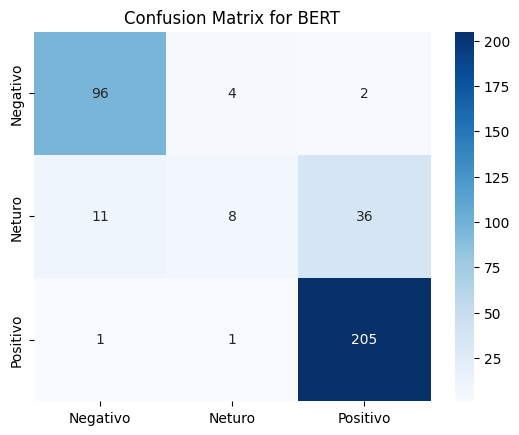

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.87      0.95      0.91       102
           1       0.56      0.49      0.52        55
           2       0.93      0.92      0.92       207

    accuracy                           0.86       364
   macro avg       0.79      0.79      0.79       364
weighted avg       0.86      0.86      0.86       364

*** Best Epoch: 2, Best W-F1: 0.8590359958511139 ***


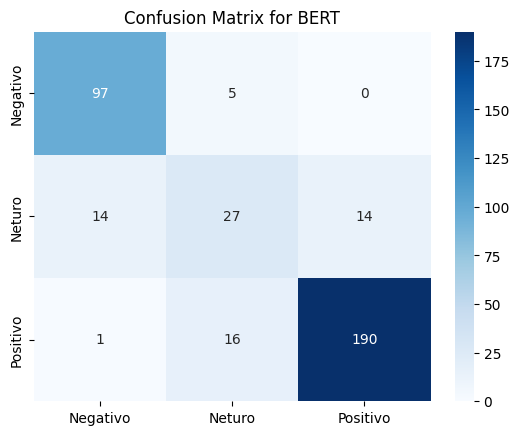

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       102
           1       0.43      0.69      0.53        55
           2       0.95      0.81      0.87       207

    accuracy                           0.82       364
   macro avg       0.77      0.80      0.77       364
weighted avg       0.86      0.82      0.83       364



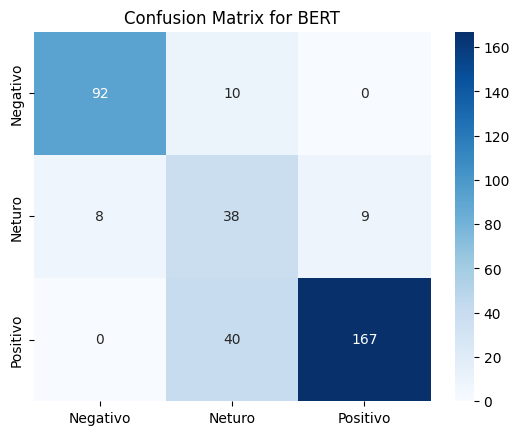

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       102
           1       0.54      0.56      0.55        55
           2       0.93      0.91      0.92       207

    accuracy                           0.86       364
   macro avg       0.79      0.79      0.79       364
weighted avg       0.86      0.86      0.86       364



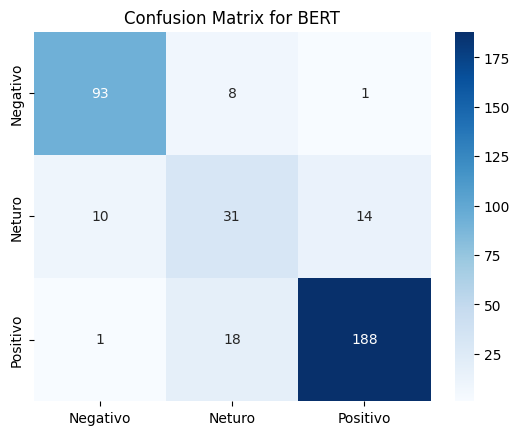

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       102
           1       0.57      0.49      0.53        55
           2       0.91      0.93      0.92       207

    accuracy                           0.87       364
   macro avg       0.80      0.78      0.79       364
weighted avg       0.86      0.87      0.86       364

*** Best Epoch: 5, Best W-F1: 0.8611094341476575 ***


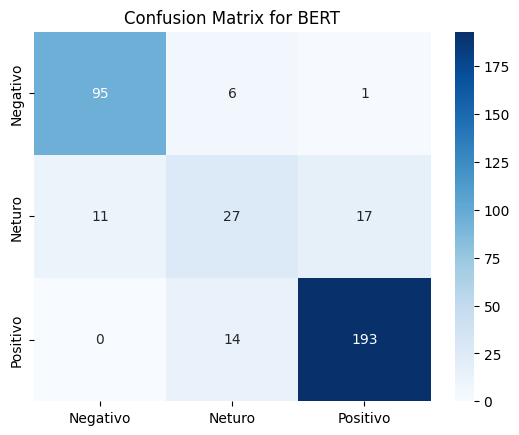


Training model: PATANA



tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/patana-chilean-spanish-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.79      0.97      0.87       102
           1       0.70      0.29      0.41        55
           2       0.92      0.96      0.94       207

    accuracy                           0.86       364
   macro avg       0.80      0.74      0.74       364
weighted avg       0.85      0.86      0.84       364

*** Best Epoch: 1, Best W-F1: 0.8389821303026207 ***


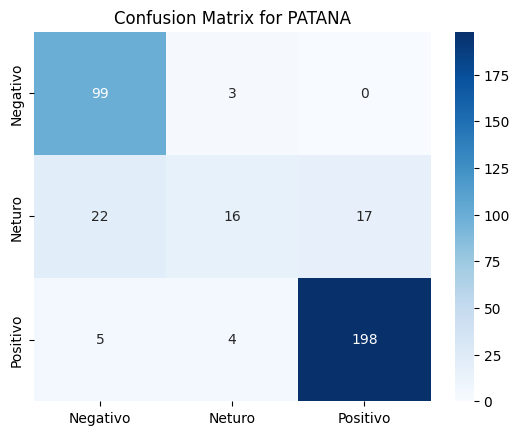

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       102
           1       0.68      0.51      0.58        55
           2       0.92      0.95      0.94       207

    accuracy                           0.89       364
   macro avg       0.83      0.81      0.82       364
weighted avg       0.88      0.89      0.88       364

*** Best Epoch: 2, Best W-F1: 0.8806893802513749 ***


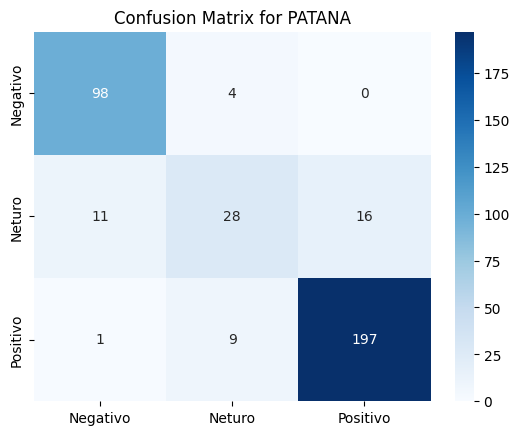

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.89      0.95      0.92       102
           1       0.63      0.53      0.57        55
           2       0.93      0.94      0.94       207

    accuracy                           0.88       364
   macro avg       0.82      0.81      0.81       364
weighted avg       0.88      0.88      0.88       364



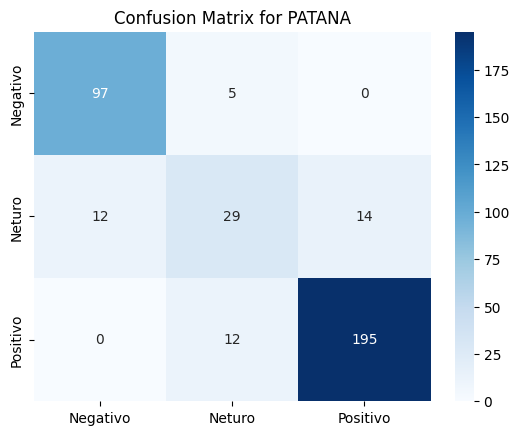

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       102
           1       0.77      0.44      0.56        55
           2       0.91      0.98      0.94       207

    accuracy                           0.89       364
   macro avg       0.86      0.79      0.81       364
weighted avg       0.88      0.89      0.88       364



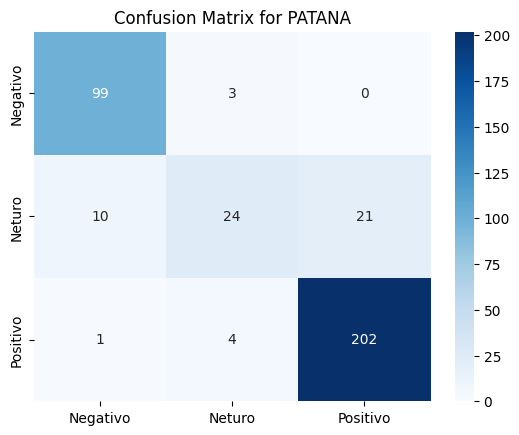

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.79      0.88       102
           1       0.56      0.51      0.53        55
           2       0.88      0.99      0.93       207

    accuracy                           0.86       364
   macro avg       0.81      0.76      0.78       364
weighted avg       0.86      0.86      0.86       364



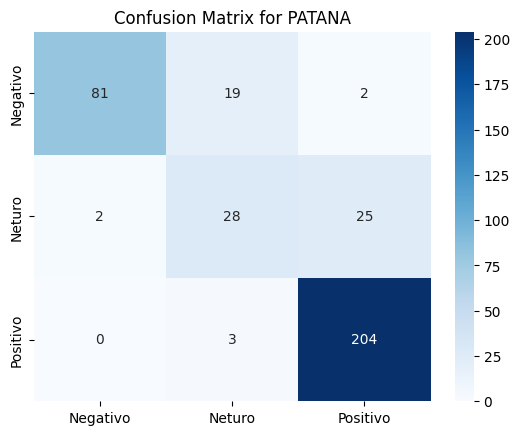


Training model: TULIO



tokenizer_config.json:   0%|          | 0.00/368 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/729k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/tulio-chilean-spanish-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       102
           1       0.56      0.58      0.57        55
           2       0.95      0.88      0.91       207

    accuracy                           0.86       364
   macro avg       0.79      0.81      0.80       364
weighted avg       0.86      0.86      0.86       364

*** Best Epoch: 1, Best W-F1: 0.858383451542563 ***


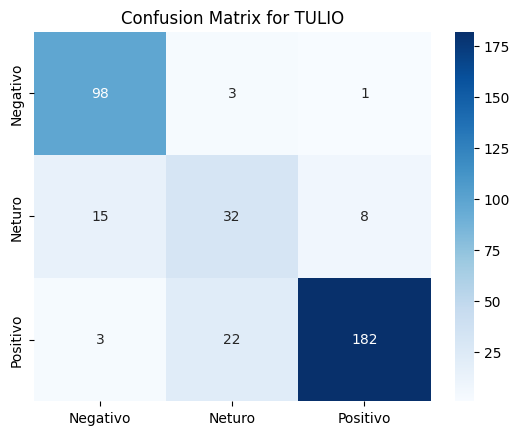

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.96      0.91       102
           1       0.74      0.45      0.56        55
           2       0.92      0.96      0.94       207

    accuracy                           0.88       364
   macro avg       0.84      0.79      0.80       364
weighted avg       0.88      0.88      0.87       364

*** Best Epoch: 2, Best W-F1: 0.874231839029831 ***


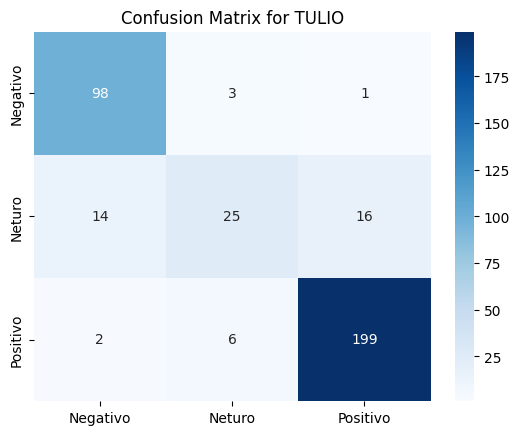

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       102
           1       0.60      0.47      0.53        55
           2       0.91      0.96      0.93       207

    accuracy                           0.87       364
   macro avg       0.81      0.78      0.79       364
weighted avg       0.86      0.87      0.87       364



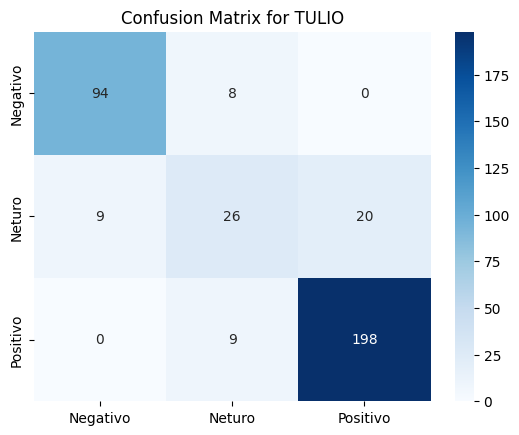

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       102
           1       0.59      0.64      0.61        55
           2       0.92      0.98      0.95       207

    accuracy                           0.88       364
   macro avg       0.83      0.81      0.82       364
weighted avg       0.88      0.88      0.88       364

*** Best Epoch: 4, Best W-F1: 0.8795209306778161 ***


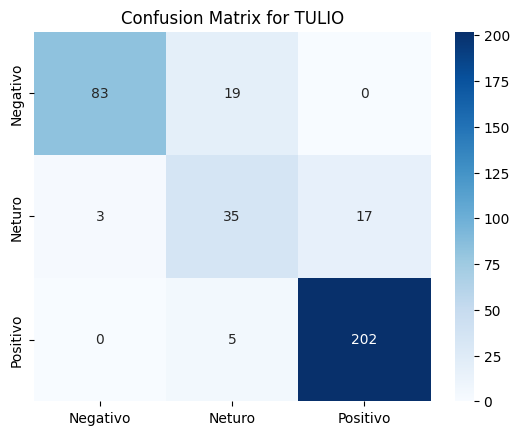

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       102
           1       0.60      0.60      0.60        55
           2       0.93      0.96      0.94       207

    accuracy                           0.88       364
   macro avg       0.82      0.81      0.81       364
weighted avg       0.88      0.88      0.88       364



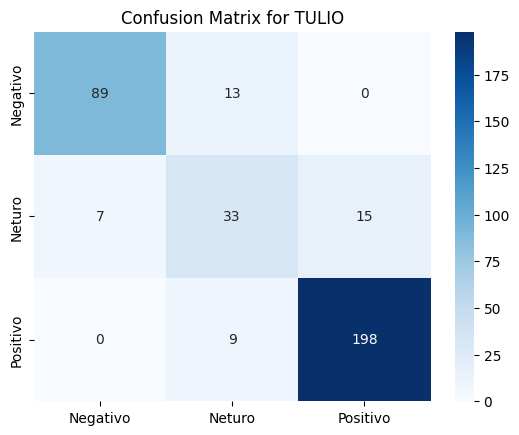


Training model: ROBERTA



tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/851k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/509k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.21M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at bertin-project/bertin-roberta-base-spanish and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       102
           1       0.00      0.00      0.00        55
           2       0.57      1.00      0.73       207

    accuracy                           0.57       364
   macro avg       0.19      0.33      0.24       364
weighted avg       0.32      0.57      0.41       364

*** Best Epoch: 1, Best W-F1: 0.41231885452550954 ***


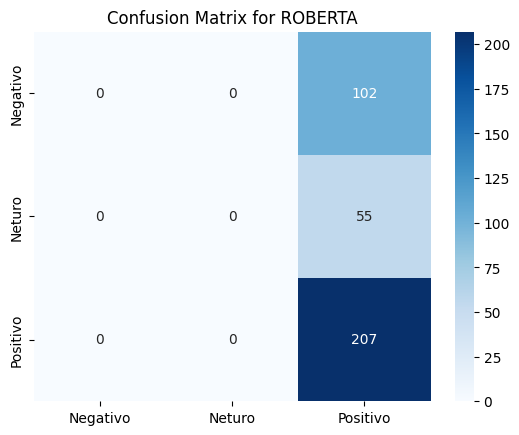

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       102
           1       0.00      0.00      0.00        55
           2       0.91      0.91      0.91       207

    accuracy                           0.80       364
   macro avg       0.52      0.64      0.57       364
weighted avg       0.70      0.80      0.74       364

*** Best Epoch: 2, Best W-F1: 0.7395487392965678 ***


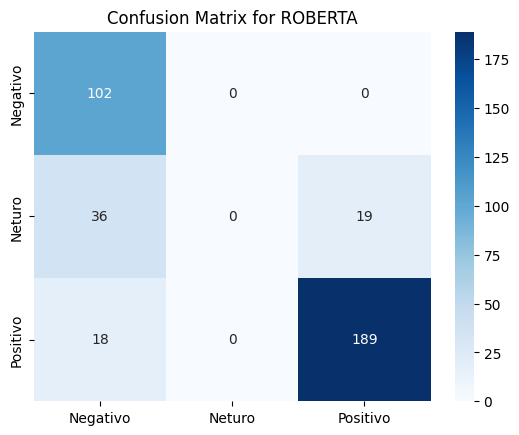

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       102
           1       0.58      0.58      0.58        55
           2       0.93      0.93      0.93       207

    accuracy                           0.87       364
   macro avg       0.81      0.81      0.81       364
weighted avg       0.87      0.87      0.87       364

*** Best Epoch: 3, Best W-F1: 0.8736073292248733 ***


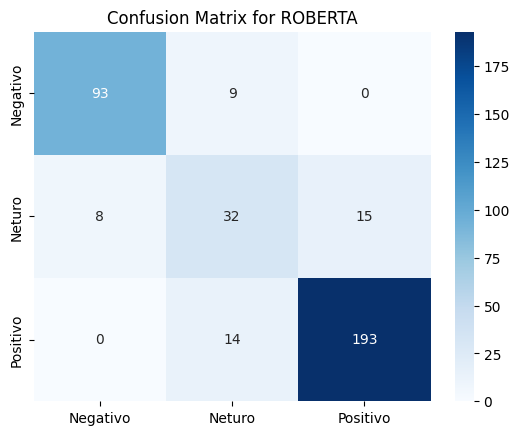

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       102
           1       0.57      0.56      0.57        55
           2       0.92      0.96      0.94       207

    accuracy                           0.87       364
   macro avg       0.81      0.79      0.80       364
weighted avg       0.87      0.87      0.87       364



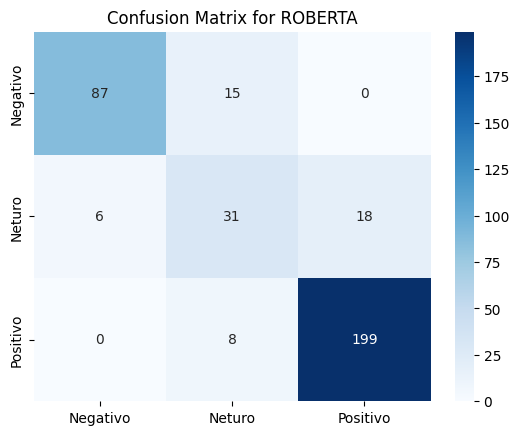

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.94      0.79      0.86       102
           1       0.41      0.71      0.52        55
           2       0.94      0.83      0.88       207

    accuracy                           0.80       364
   macro avg       0.76      0.78      0.75       364
weighted avg       0.86      0.80      0.82       364



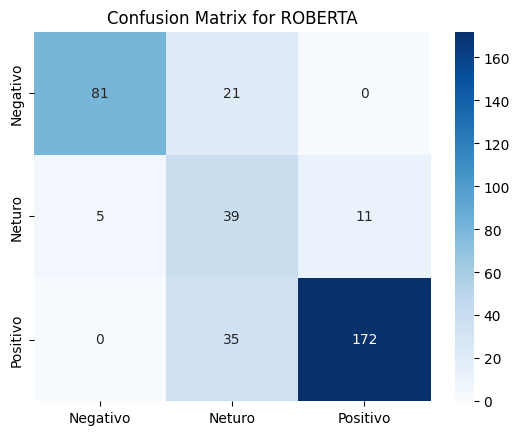


Training model: ALBERT



tokenizer_config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/832 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/237M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at dccuchile/albert-xlarge-spanish and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/363 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 16.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 7.06 MiB is free. Process 4609 has 14.74 GiB memory in use. Of the allocated memory 12.87 GiB is allocated by PyTorch, and 1.74 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [13]:
loss_fn = nn.CrossEntropyLoss()

final_results_df = pd.DataFrame()

save_directory = '/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea4/Models/'
os.makedirs(save_directory, exist_ok=True)

for model_alias, model_path in tqdm(models.items()):
    print(f"\nTraining model: {model_alias}\n")

    #  BERT, PATANA, TULIO, ROBERTA, ALBERT, LONGFORMER
    if model_alias == 'LONGFORMER':
        max_lenth = 4096
    else:
        max_lenth = 512


    best_epoch = 0
    best_wf1 = 0

    tokenizer = AutoTokenizer.from_pretrained(model_path, token=access_token)
    model_config = AutoConfig.from_pretrained(model_path, num_labels=n_labels, token=access_token)
    model = AutoModelForSequenceClassification.from_pretrained(model_path,
                                                               config=model_config,
                                                               token=access_token,
                                                               load_in_4bit=False,
                                                               load_in_8bit=False
                                                               )
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    for epoch in tqdm(range(epochs)):
        # TRAINING
        epoch_true_labels = []
        epoch_predicted_labels = []
        total_loss = 0

        t_bar = tqdm(train_dataloader)
        model.train()

        for step_counter, (labels, text_1, text_2) in enumerate(t_bar):
            labels = labels.to(device)
            inputs = tokenizer(text_1, text_2, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            inputs['labels'] = labels
            inputs = {k: v.type(torch.long).to(device) for k, v in inputs.items()}

            model.zero_grad()
            optimizer.zero_grad()

            outputs = model(**inputs)

            loss = loss_fn(outputs.logits, labels)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()

            predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

            epoch_true_labels.extend(labels.cpu().tolist())
            epoch_predicted_labels.extend(predicted_labels)

            epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
            t_bar.set_description(f'Training... EPOCH {epoch + 1} Step Loss {loss.item():4f}, Epoch Accuracy {epoch_report["accuracy"]:4f}')
            t_bar.refresh()

        # EVALUATION
        epoch_true_labels = []
        epoch_predicted_labels = []
        total_loss = 0

        v_bar = tqdm(test_dataloader)
        model.eval()

        for step_counter, (labels, text_1, text_2) in enumerate(v_bar):
            labels = labels.to(device)
            inputs = tokenizer(text_1, text_2, return_tensors='pt', padding=True, truncation=True, max_length=max_length)
            inputs['labels'] = labels
            inputs = {k: v.type(torch.long).to(device) for k, v in inputs.items()}

            outputs = model(**inputs)

            loss = loss_fn(outputs.logits, labels)

            total_loss += loss.item()

            predicted_labels = outputs.logits.argmax(dim=1).cpu().tolist()

            epoch_true_labels.extend(labels.cpu().tolist())
            epoch_predicted_labels.extend(predicted_labels)

            epoch_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
            v_bar.set_description(f'Training... EPOCH {epoch + 1} Step Loss {loss.item():4f}, Avg Accuracy {epoch_report["accuracy"]:4f}')
            v_bar.refresh()

        evaluations_report = classification_report(epoch_true_labels, epoch_predicted_labels, output_dict=True)
        print(classification_report(epoch_true_labels, epoch_predicted_labels))
        epoch_wf1 = evaluations_report['weighted avg']['f1-score']

        if epoch_wf1 > best_wf1:
            best_epoch = epoch + 1
            best_wf1 = epoch_wf1
            best_report = evaluations_report
            print(f'*** Best Epoch: {best_epoch}, Best W-F1: {best_wf1} ***')

            model.save_pretrained(f'{save_directory}/{model_alias}')

        conf_matrix = confusion_matrix(epoch_true_labels, epoch_predicted_labels)

        # Plot confusion matrix
        fig, ax = plt.subplots()
        plt.title(f'Confusion Matrix for {model_alias}')
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                    xticklabels={'Negativo': 0, 'Neturo': 1, 'Positivo': 2},
                    yticklabels={'Negativo': 0, 'Neturo': 1, 'Positivo': 2})
        plt.show()

    transformer_results_df = pd.DataFrame(best_report).T
    transformer_results_df['model'] = model_alias
    transformer_results_df['best_epoch'] = best_epoch
    transformer_results_df = transformer_results_df.drop(columns=['support'])
    transformer_results_df = transformer_results_df.reset_index()
    transformer_results_df.rename(columns={'index': 'class'}, inplace=True)

    final_results_df = pd.concat([final_results_df, transformer_results_df], ignore_index=True)

### Resultados

In [ ]:
final_results_df.to_pickle(f'/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea4/Results/LAB-4_Final_results.pkl')
final_results_df.to_excel(f'/content/drive/My Drive/2024-02/Analitica_textual_con_ML/Tarea4/Results/LAB-4_Final_results.xlsx')
final_results_df

,class,precision,recall,f1-score,model,best_epoch
0,0,0.741071,0.741071,0.741071,PATANA,5
1,1,0.590909,0.558282,0.574132,PATANA,5
2,2,0.931787,0.943370,0.937543,PATANA,5
3,accuracy,0.857858,0.857858,0.857858,PATANA,5
4,macro avg,0.754589,0.747575,0.750916,PATANA,5
5,weighted avg,0.854787,0.857858,0.856221,PATANA,5
6,0,0.736000,0.821429,0.776371,TULIO,3
7,1,0.626761,0.546012,0.583607,TULIO,3
8,2,0.933060,0.943370,0.938187,TULIO,3
9,accuracy,0.864865,0.864865,0.864865,TULIO,3


In [ ]:
final_results_df.loc[final_results_df['class'] == 'weighted avg'].sort_values(by=['f1-score'])

,class,precision,recall,f1-score,model,best_epoch
5,weighted avg,0.854787,0.857858,0.856221,PATANA,5
11,weighted avg,0.860990,0.864865,0.862191,TULIO,3


In [ ]:
final_results_dfTodos = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/Lab4/ResultadosCompletos/LAB-4_Final_results.pkl')
final_results_dfTodos

,class,precision,recall,f1-score,model,best_epoch
0,0,0.741071,0.741071,0.741071,PATANA,5
1,1,0.590909,0.558282,0.574132,PATANA,5
2,2,0.931787,0.943370,0.937543,PATANA,5
3,accuracy,0.857858,0.857858,0.857858,PATANA,5
4,macro avg,0.754589,0.747575,0.750916,PATANA,5
5,weighted avg,0.854787,0.857858,0.856221,PATANA,5
6,0,0.736000,0.821429,0.776371,TULIO,3
7,1,0.626761,0.546012,0.583607,TULIO,3
8,2,0.933060,0.943370,0.938187,TULIO,3
9,accuracy,0.864865,0.864865,0.864865,TULIO,3
